## Загрузка необходимых модулей

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score
from random import randint
import seaborn as sns
from sklearn.cluster import KMeans

plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

# Часть I
* Загрузка тренировочного датасета
* Анализ данных
* Исправление данных

In [2]:
df = pd.read_csv('train.csv')
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [3]:
# Выбор и исправление явно неверных данных

def data_correction(df):
    df.loc[df['Rooms']==19,'Rooms']=1
    df.loc[df['Rooms']==10,'Rooms']=2
    df.loc[df['Rooms']==6,'Rooms']=2
    df.loc[(df['Rooms']==5) & (df['Square']<50),'Rooms']=2

    df.loc[(df['Square']>400),'Square']=df.loc[(df['Square']>400),'Square']/10
    df.loc[(df['LifeSquare']>400),'LifeSquare']=df.loc[(df['LifeSquare']>400),'LifeSquare']/10
    df.loc[(df['KitchenSquare']>25) & (df['KitchenSquare']>df['LifeSquare']),'KitchenSquare'] = df.loc[(df['KitchenSquare']>25) & (df['KitchenSquare']>df['LifeSquare']),'KitchenSquare']/10
    df.loc[(df['KitchenSquare']>25) & (df['KitchenSquare']>df['Square']-df['Square']/10),'KitchenSquare'] = df.loc[(df['KitchenSquare']>25) & (df['KitchenSquare']>df['Square']-df['Square']/10),'KitchenSquare']/10
    df.loc[(df['KitchenSquare']>25)& (df['Square']<100),'KitchenSquare'] = df.loc[(df['KitchenSquare']>25)& (df['Square']<100),'KitchenSquare']/10+10
    df.loc[(df['Floor']>df['HouseFloor']) & (df['HouseFloor']==0),'HouseFloor'] = df.loc[(df['Floor']>df['HouseFloor']) & (df['HouseFloor']==0),'Floor']
    df.loc[df['Floor']>df['HouseFloor'],'Floor'] = df.loc[:,'Floor'].quantile(0.5)
    df.loc[df['Floor']>df['HouseFloor'],'HouseFloor'] = df.loc[:,'HouseFloor'].quantile(0.5)
    df.loc[df['LifeSquare']<1,'LifeSquare'] = df.loc[df['LifeSquare']<1,'LifeSquare']*100
    df.loc[df['LifeSquare']<10,'LifeSquare'] = df.loc[df['LifeSquare']<10,'LifeSquare']*10
    df.loc[df['Square']<1,'Square'] = df.loc[df['Square']<1,'Square']*100
    df.loc[df['Square']<10,'Square']= df.loc[df['Square']<10,'Square']*10
    df.loc[df['KitchenSquare']<1,'KitchenSquare']=df.loc[df['KitchenSquare']<1,'KitchenSquare']*100
    df.loc[df['KitchenSquare']<2,'KitchenSquare']=df.loc[df['KitchenSquare']<2,'KitchenSquare']*10
    df.loc[(df['LifeSquare']>200) & (df['Square']<100),'LifeSquare']=df.loc[(df['LifeSquare']>200) & (df['Square']<100),'LifeSquare']/10
    # оставшиеся случаи, когда общая площадь превышает жилую решается обменом их значений
    for i in df.loc[df['LifeSquare']>df['Square'],'Id']:
        n=df.loc[df['Id']==i,'LifeSquare']
        m=df.loc[df['Id']==i,'Square']
        df.loc[df['Id']==i,'LifeSquare']=m
        df.loc[df['Id']==i,'Square']=n
    return df

df = data_correction(df)

In [4]:
# берем средние значения LifeSquare по каждому району - и используем их для заполнения пропущенных данных
df['LifeSquare']=df['LifeSquare'].fillna(df.groupby('Rooms')['LifeSquare'].transform('mean'))

In [5]:
# Исправление дат постройки
df.loc[df['HouseYear']==20052011,'HouseYear'] = 2011 # какую из двух пытались на самом деле ввести понять невозможно; просто выбираем одну из двух
df.loc[df['HouseYear']==4968,'HouseYear'] = 1968 # была явная ошибка ввода: вместо '1' ввели '4'

#### Попытка оценить влияние категориальных факторов на цену

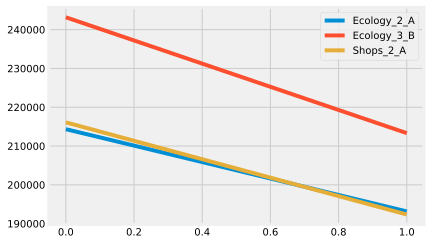

In [6]:
df_cat = pd.get_dummies(df.select_dtypes(include='object'),columns = df.select_dtypes(include='object').columns)
df_cat['Price']=df['Price']
plt.plot(df_cat.groupby('Ecology_2_A').mean().index,df_cat.groupby('Ecology_2_A').mean()['Price'])
plt.plot(df_cat.groupby('Ecology_3_B').mean().index,df_cat.groupby('Ecology_3_B').mean()['Price'])
plt.plot(df_cat.groupby('Shops_2_A').mean().index,df_cat.groupby('Shops_2_A').mean()['Price'])
plt.legend(labels=['Ecology_2_A', 'Ecology_3_B','Shops_2_A'],loc='upper right')

plt.show()

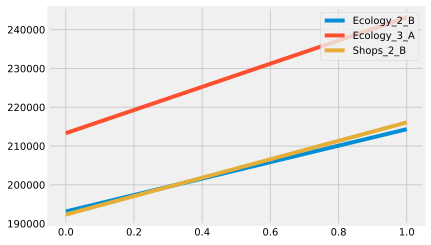

In [7]:
plt.plot(df_cat.groupby('Ecology_2_B').mean().index,df_cat.groupby('Ecology_2_B').mean()['Price'])
plt.plot(df_cat.groupby('Ecology_3_A').mean().index,df_cat.groupby('Ecology_3_A').mean()['Price'])
plt.plot(df_cat.groupby('Shops_2_B').mean().index,df_cat.groupby('Shops_2_B').mean()['Price'])
plt.legend(labels=['Ecology_2_B', 'Ecology_3_A','Shops_2_B'],loc='upper right')

plt.show()

In [8]:
x_eco3=df.loc[df['Ecology_3']=='A','Ecology_3'].count()
x_eco2=df.loc[df['Ecology_2']=='A','Ecology_2'].count()
x_shop2=df.loc[df['Shops_2']=='A','Shops_2'].count()
print (f'Значений A для параметра Shops_2: {x_shop2}\n\
Значений A для параметра Ecology_2: {x_eco2}\n\
Значений A для параметра Ecology_3: {x_eco3}')

Значений A для параметра Shops_2: 825
Значений A для параметра Ecology_2: 97
Значений A для параметра Ecology_3: 275


##### т.к. все 3 параметра принимают значение A в меньшинстве случаев, для создания оценки будет использовано значение B (B=1 для положительно влияющих на цену факторов, B=-1 - для отрицательно влияющих)

In [9]:
# Столбцы Ecology_3, Ecology_2, Shops_2 имеют только 2 возможных значения, поэтому делать преобразование с помощью функции dummies нет смысла
# Вместо этого примем, что часть значений A / B принимает значения 1/0/-1. Основание выбора соответствующих значений - графический анализ;
# целью преобразования является создание специальной шкалы, рост оценки по которой соответсвовал бы росту цены.
df.loc[df['Ecology_3']=='A','Ecology_3']=0
df.loc[df['Ecology_3']=='B','Ecology_3']=-1
df.loc[df['Ecology_2']=='A','Ecology_2']=0
df.loc[df['Ecology_2']=='B','Ecology_2']=1
df.loc[df['Shops_2']=='A','Shops_2']=0
df.loc[df['Shops_2']=='B','Shops_2']=1 #

In [10]:
df['DistrictId']

0        27
1        22
2         1
3         1
4        94
       ... 
9995     61
9996     27
9997    178
9998     21
9999     94
Name: DistrictId, Length: 10000, dtype: int64

In [11]:
# Шкалирование данных; на дальнейших этапах будут проводиться разные преобразования;
# чтобы разный масштаб значений разных параметров не влиял на результаты - сразу выполним масштабирование
data_scaler = MinMaxScaler(copy = False)
# df['DistrictId'] = df['DistrictId'].astype('str')
# в первом (индекс = 0) столбце содержится поле Id; его масштабировать не нужно
df_scaled = pd.DataFrame(data_scaler.fit_transform(df.iloc[:,1:-1]),columns = df.iloc[:,1:-1].columns)
df.iloc[:,1:-1] = df_scaled

#### Обзор значений, сгруппированных по сумме 'Shops_2', 'Ecology_2', 'Ecology_3'

In [12]:
df.groupby(df['Shops_2']+df['Ecology_2']+df['Ecology_3']).mean()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0.0,9154.142857,0.291866,0.328571,0.132894,0.088438,0.187708,0.156794,0.112685,0.635714,0.780421,0.000000,0.0,0.121622,0.084589,0.000000,0.076304,0.000000,0.000000,0.000000,159386.651546
1.0,8288.263982,0.274408,0.380089,0.166191,0.124118,0.175203,0.169013,0.108000,0.698210,0.182115,0.907159,0.0,0.251935,0.189239,0.014153,0.302687,0.154735,0.088416,0.092841,193458.589742
2.0,8386.957355,0.236620,0.376795,0.154741,0.115315,0.185581,0.168881,0.111409,0.680353,0.222063,1.000000,0.0,0.340566,0.283270,0.061910,0.226992,0.220729,0.194022,1.000000,215416.899449
3.0,8539.665455,0.275755,0.384000,0.144412,0.101951,0.176482,0.150865,0.102257,0.633653,0.530462,1.000000,1.0,0.386830,0.264763,0.042347,0.337980,0.416970,0.181660,1.000000,243179.560704


In [13]:
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,0.129187,0.6,0.381421,0.182017,0.232558,0.073171,0.077586,0.945455,0.144527,1.0,0.0,0.148649,0.154851,0.000000,NaN,0.000000,0.000000,1.0,305018.871089
1,3013,0.105263,0.2,0.091828,0.056704,0.186047,0.146341,0.060345,0.509091,0.227141,1.0,0.0,0.405405,0.319270,0.007092,0.243968,0.166667,0.000000,1.0,177734.553407
2,8215,0.004785,0.6,0.240138,0.166360,0.232558,0.024390,0.137931,0.709091,0.049072,1.0,0.0,0.445946,0.269257,0.000000,0.049495,0.500000,0.043478,1.0,282078.720850
3,2352,0.004785,0.2,0.094051,0.068371,0.232558,0.219512,0.181034,0.609091,0.013648,1.0,0.0,0.013514,0.005075,0.000000,NaN,0.000000,0.043478,1.0,168106.007630
4,13866,0.449761,0.4,0.186000,0.125593,0.209302,0.365854,0.129310,0.563636,0.541896,1.0,0.0,0.445946,0.449326,0.014184,NaN,0.000000,0.260870,1.0,343995.102962


##### Выявлены некоторые закономерности:
* Чем больше баллов (df['Shops_2']+df['Ecology_2']+df['Ecology_3']), тем больше Ecology_1.
* Больше баллов - больше цена.
* Ecology_1 может отражать "хорошие" черты квартир (раз цена увеличивается)
* Вычисенные баллы - "хорошие" (т.к. цена увеличивается)
* Самым маленьким значениям Shop_1 соответствует группа с самой низкой средней ценой.
* Прямая ("чем больше один, тем больше другой") связь с суммой баллов видна по параметру Social_1, Helthcare_2 и Shops_1

#### Т.к. качество полученной оценки достаточно хорошее (отражает связь с несколькими переменными), создается новый столбец (новые данные)

In [14]:
df['Score'] = df['Shops_2']+df['Ecology_2']+df['Ecology_3']

#### Визуальное представление связи между новым параметром и имеющимися данными

* Цена

<BarContainer object of 4 artists>

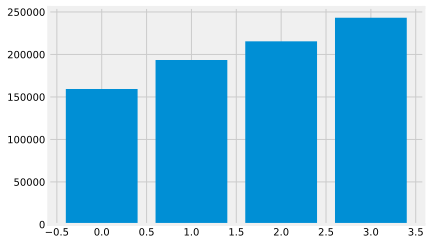

In [15]:
plt.bar(df.groupby('Score').mean().index,df.groupby('Score').mean()['Price'])

* Social_1

<BarContainer object of 4 artists>

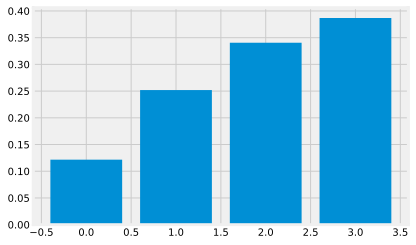

In [16]:
plt.bar(df.groupby('Score').mean().index,df.groupby('Score').mean()['Social_1'])

* Helthcare_2

<BarContainer object of 4 artists>

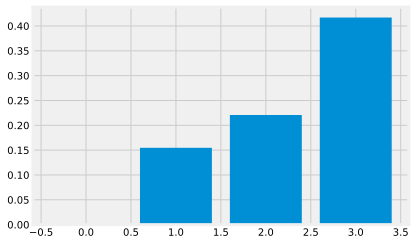

In [17]:
plt.bar(df.groupby('Score').mean().index,df.groupby('Score').mean()['Helthcare_2'])

* Shops_1

<BarContainer object of 4 artists>

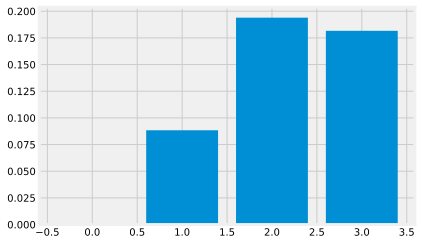

In [18]:
plt.bar(df.groupby('Score').mean().index,df.groupby('Score').mean()['Shops_1'])

* Ecology_1
#### Разнонаправленность параметра по отношению к данной оценки - связь может быть сложной или отсутствовать вовсе

<BarContainer object of 4 artists>

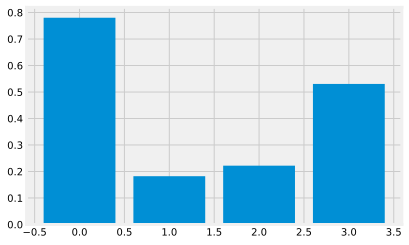

In [19]:
plt.bar(df.groupby('Score').mean().index,df.groupby('Score').mean()['Ecology_1'])

#### Для упрощения работы с данными можно разбить их на группы: низкие, средние, высокие и очень высокие значения.
##### Границы значений подбираются индивидуально, по графику и по значениям np.percentile.

* Группируем данные по ценам (сгруппировать почти невозможно, т.к. цены почти наверняка разные);
* Строим графики распределения полученных групп по большинству параметров, выявляя нормально распределенные или четко сгруппированные
* Всего проанализировано 14 признаков, выбрано к использованию 13 (исключен Social_3 и Shop_2, т.к. по графику невозможно вычленить различные группы квартир или группы слишком маленькие и могут негативно сказться на качестве модели)

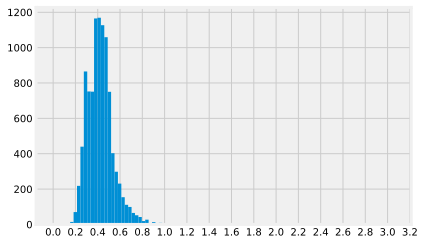

In [20]:
fig, ax = plt.subplots()
ax.hist(df.loc[df['Rooms']!=0,'Square']/df.loc[df['Rooms']!=0,'Rooms'],bins=100)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))

In [21]:
np.percentile(df.loc[df['Rooms']!=0,'Square']/df.loc[df['Rooms']!=0,'Rooms'], [0, 5, 75, 95, 100])

array([0.        , 0.25956905, 0.48495635, 0.64406181, 3.05881534])

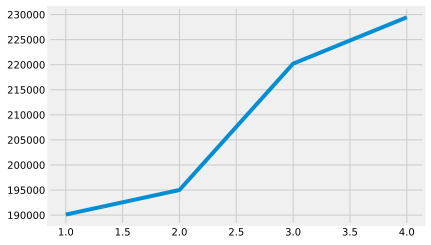

In [22]:
x0=np.percentile(df.loc[df['Rooms']!=0,'Square']/df.loc[df['Rooms']!=0,'Rooms'], [0, 5, 75, 95, 100])

df['Square_Rooms_group']=''
df.loc[(df['Square']/df['Rooms'])<x0[1],'Square_Rooms_group']=1
df.loc[(df['Square']/df['Rooms']>=x0[1])&(df['Square']/df['Rooms']<x0[2]),'Square_Rooms_group']=3
df.loc[(df['Square']/df['Rooms']>=x0[2])&(df['Square']/df['Rooms']<x0[3]),'Square_Rooms_group']=2
df.loc[df['Square']/df['Rooms']>=x0[3],'Square_Rooms_group']=4
df.loc[df['Rooms']==0,'Square_Rooms_group']=4
df2 = df.groupby('Square_Rooms_group').mean()
plt.plot(df2.index,df2['Price'])
plt.show()

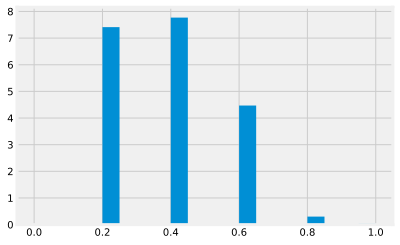

In [23]:
df1 = df.groupby('Price').mean()
plt.hist(df1.sort_values('Rooms')['Rooms'],bins=20,density=True)
plt.show()

In [24]:
np.percentile(df['Rooms'], [0, 25, 80, 98.5, 100])

array([0. , 0.2, 0.6, 0.8, 1. ])

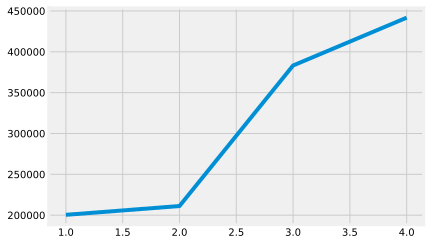

In [25]:
x1=np.percentile(df['Rooms'], [0, 25, 80, 98.5, 100])
df['Rooms_group']=''
df.loc[df['Rooms']<x1[1],'Rooms_group']=1
df.loc[(df['Rooms']>=x1[1])&(df['Rooms']<=x1[2]),'Rooms_group']=2
df.loc[(df['Rooms']>x1[2])&(df['Rooms']<=x1[3]),'Rooms_group']=3
df.loc[df['Rooms']>x1[3],'Rooms_group']=4

df2 = df.groupby('Rooms_group').mean()
plt.plot(df2.index,df2['Price'])
plt.show()

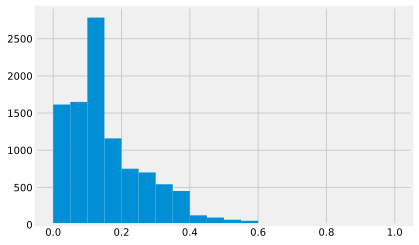

In [26]:
df1 = df.groupby('Price').mean()
plt.hist(df1.sort_values('Floor')['Floor'],bins=20)
plt.show()

In [27]:
np.percentile(df['Floor'], [0, 30, 65, 95, 100])

array([0.        , 0.09756098, 0.17073171, 0.3902439 , 1.        ])

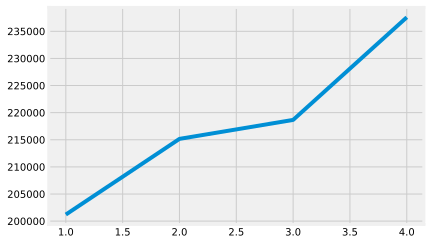

In [28]:
x2=np.percentile(df['Floor'], [0, 30, 65, 95, 100])
df['Floor_group']=''
df.loc[df['Floor']<x2[1],'Floor_group']=1
df.loc[(df['Floor']>=x2[1])&(df['Floor']<x2[2]),'Floor_group']=2
df.loc[(df['Floor']>=x2[2])&(df['Floor']<x2[3]),'Floor_group']=3
df.loc[df['Floor']>=x2[3],'Floor_group']=4

df2 = df.groupby('Floor_group').mean()
plt.plot(df2.index,df2['Price'])
plt.show()

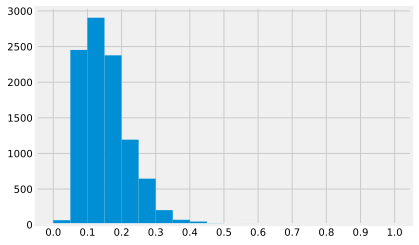

In [29]:
df1 = df.groupby('Price').mean()
fig, ax = plt.subplots()
ax.hist(df1.sort_values('Square')['Square'],bins=20)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
plt.show()

In [30]:
np.percentile(df['Square'], [0, 1, 50, 90, 100])

array([0.        , 0.05513986, 0.14141291, 0.25020952, 1.        ])

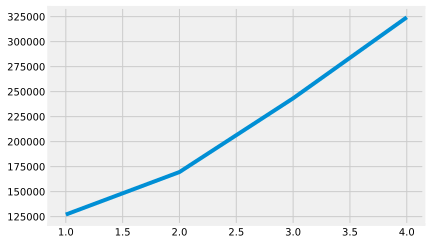

In [31]:
x3=np.percentile(df['Square'], [0, 1, 50, 90, 100])
df['Square_group']=''
df.loc[df['Square']<x3[1],'Square_group']=1
df.loc[(df['Square']>=x3[1])&(df['Square']<x3[2]),'Square_group']=2
df.loc[(df['Square']>=x3[2])&(df['Square']<x3[3]),'Square_group']=3
df.loc[df['Square']>=x3[3],'Square_group']=4

df2 = df.groupby('Square_group').mean()
plt.plot(df2.index,df2['Price'])
plt.show()

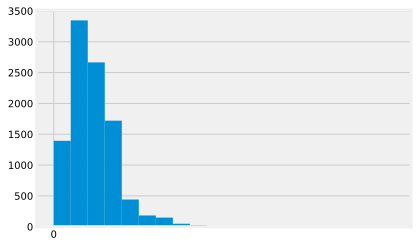

In [32]:
df1 = df.groupby('Price').mean()
fig, ax = plt.subplots()
ax.hist(df1.sort_values('LifeSquare')['LifeSquare'],bins=20)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
plt.show()

In [33]:
np.percentile(df['LifeSquare'], [0, 8, 80, 90, 100])

array([0.        , 0.0430056 , 0.16438082, 0.18903717, 1.        ])

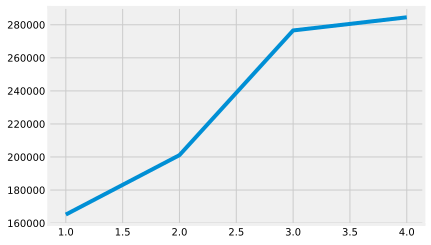

In [34]:
x4=np.percentile(df['LifeSquare'], [0, 8, 80, 90, 100])
df['LifeSquare_group']=''
df.loc[df['LifeSquare']<x4[1],'LifeSquare_group']=1
df.loc[(df['LifeSquare']>=x4[1])&(df['LifeSquare']<x4[2]),'LifeSquare_group']=2
df.loc[(df['LifeSquare']>=x4[2])&(df['LifeSquare']<x4[3]),'LifeSquare_group']=3
df.loc[df['LifeSquare']>=x4[3],'LifeSquare_group']=4

df2 = df.groupby('LifeSquare_group').mean()
plt.plot(df2.index,df2['Price'])
plt.show()

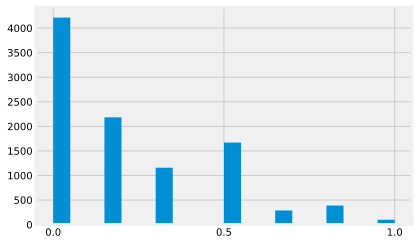

In [35]:
df1 = df.groupby('Price').mean()
fig, ax = plt.subplots()
ax.hist(df1.sort_values('Helthcare_2')['Helthcare_2'],bins=20)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
plt.show()

In [36]:
np.percentile(df['Helthcare_2'], [0, 50, 75, 90, 100])

array([0.        , 0.16666667, 0.33333333, 0.5       , 1.        ])

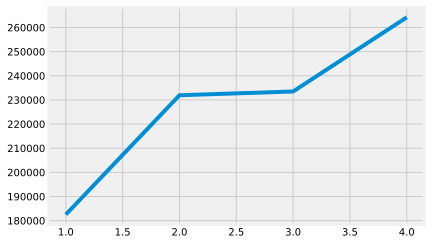

In [37]:
x5=np.percentile(df['Helthcare_2'], [0, 50, 75, 90, 100])
df['Helthcare_2_group']=''
df.loc[df['Helthcare_2']<x5[1],'Helthcare_2_group']=1
df.loc[(df['Helthcare_2']>=x5[1])&(df['Helthcare_2']<=x5[2]),'Helthcare_2_group']=3
df.loc[(df['Helthcare_2']>x5[2])&(df['Helthcare_2']<=x5[3]),'Helthcare_2_group']=2
df.loc[df['Helthcare_2']>x5[3],'Helthcare_2_group']=4

df2 = df.groupby('Helthcare_2_group').mean()
plt.plot(df2.index,df2['Price'])
plt.show()

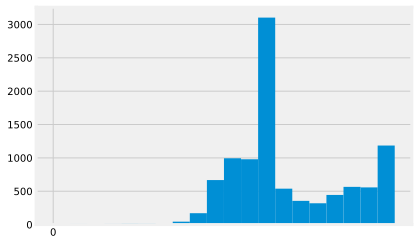

In [38]:
df1 = df.groupby('Price').mean()
fig, ax = plt.subplots()
ax.hist(df1.sort_values('HouseYear')['HouseYear'],bins=20)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
plt.show()

In [39]:
np.percentile(df['HouseYear'], [0, 10, 60, 75, 100])

array([0.        , 0.5       , 0.64545455, 0.82727273, 1.        ])

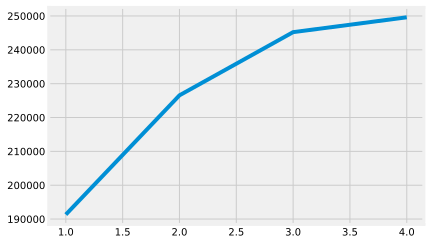

In [40]:
x6=np.percentile(df['HouseYear'], [0, 10, 60, 75, 100])
df['HouseYear_group']=''
df.loc[df['HouseYear']<x6[1],'HouseYear_group']=4
df.loc[(df['HouseYear']>=x6[1])&(df['HouseYear']<x6[2]),'HouseYear_group']=1
df.loc[(df['HouseYear']>=x6[2])&(df['HouseYear']<x6[3]),'HouseYear_group']=3
df.loc[df['HouseYear']>=x6[3],'HouseYear_group']=2

df2 = df.groupby('HouseYear_group').mean()
plt.plot(df2.index,df2['Price'])
plt.show()

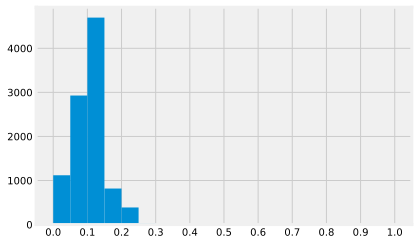

In [41]:
df1 = df.groupby('Price').mean()
fig, ax = plt.subplots()
ax.hist(df1['HouseFloor'],bins=20)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
plt.show()

In [42]:
np.percentile(df['HouseFloor'], [0, 12, 87, 95, 100])

array([0.        , 0.05172414, 0.14655172, 0.19827586, 1.        ])

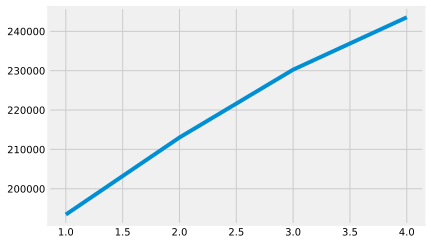

In [43]:
x7=np.percentile(df['HouseFloor'], [0, 12, 87, 95, 100])
df['HouseFloor_group']=''
df.loc[df['HouseFloor']<x7[1],'HouseFloor_group']=1
df.loc[(df['HouseFloor']>=x7[1])&(df['HouseFloor']<x7[2]),'HouseFloor_group']=2
df.loc[(df['HouseFloor']>=x7[2])&(df['HouseFloor']<x7[3]),'HouseFloor_group']=4
df.loc[df['HouseFloor']>=x7[3],'HouseFloor_group']=3

df2 = df.groupby('HouseFloor_group').mean()
plt.plot(df2.index,df2['Price'])
plt.show()

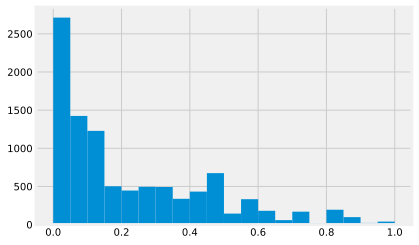

In [44]:
df1 = df.groupby('Price').mean()
fig, ax = plt.subplots()
ax.hist(df1['Ecology_1'],bins=20)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
plt.show()

In [45]:
np.percentile(df['Ecology_1'], [0, 45, 73, 96.4, 100])

array([0.        , 0.13826813, 0.3428398 , 0.78042143, 1.        ])

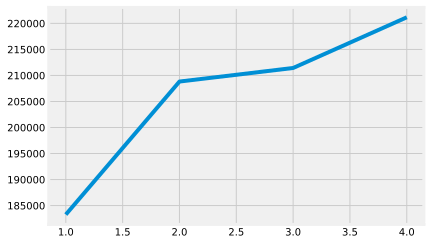

In [46]:
x8=np.percentile(df['Ecology_1'], [0, 45, 73, 96.4, 100])
df['Ecology_1_group']=''
df.loc[df['Ecology_1']<x8[1],'Ecology_1_group']=4
df.loc[(df['Ecology_1']>=x8[1])&(df['Ecology_1']<x8[2]),'Ecology_1_group']=3
df.loc[(df['Ecology_1']>=x8[2])&(df['Ecology_1']<x8[3]),'Ecology_1_group']=2
df.loc[df['Ecology_1']>=x8[3],'Ecology_1_group']=1

df2 = df.groupby('Ecology_1_group').mean()
plt.plot(df2.index,df2['Price'])
plt.show()

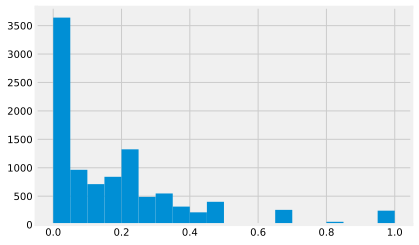

In [47]:
df1 = df.groupby('Price').mean()
fig, ax = plt.subplots()
ax.hist(df1['Shops_1'],bins=20)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
plt.show()

In [48]:
np.percentile(df['Shops_1'], [0, 36.4052, 80, 97.5, 100])

array([0.        , 0.05025861, 0.30434783, 0.82608696, 1.        ])

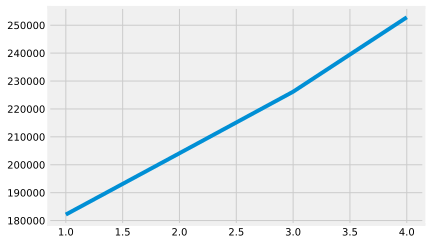

In [49]:
x9=np.percentile(df['Shops_1'], [0, 36.4052, 80, 97.5, 100])
df['Shops_1_group']=''
df.loc[df['Shops_1']<x9[1],'Shops_1_group']=1
df.loc[(df['Shops_1']>=x9[1])&(df['Shops_1']<x9[2]),'Shops_1_group']=3
df.loc[(df['Shops_1']>=x9[2])&(df['Shops_1']<x9[3]),'Shops_1_group']=4
df.loc[df['Shops_1']>=x9[3],'Shops_1_group']=2

df2 = df.groupby('Shops_1_group').mean()
plt.plot(df2.index,df2['Price'])
plt.show()

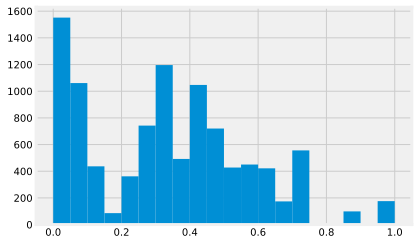

In [50]:
df1 = df.groupby('Price').mean()
fig, ax = plt.subplots()
ax.hist(df1['Social_1'],bins=20)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
plt.show()

In [51]:
np.percentile(df['Social_1'], [0, 31, 55, 86, 100])

array([0.        , 0.18918919, 0.35135135, 0.62162162, 1.        ])

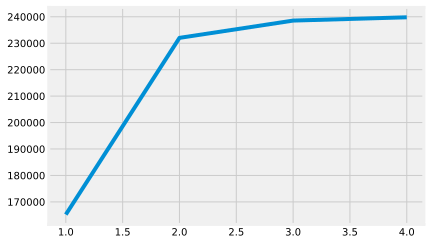

In [52]:
x10=np.percentile(df['Social_1'], [0, 31, 55, 86, 100])
df['Social_1_group']=''
df.loc[df['Social_1']<x10[1],'Social_1_group']=1
df.loc[(df['Social_1']>=x10[1])&(df['Social_1']<x10[2]),'Social_1_group']=4
df.loc[(df['Social_1']>=x10[2])&(df['Social_1']<x10[3]),'Social_1_group']=2
df.loc[df['Social_1']>=x10[3],'Social_1_group']=3

df2 = df.groupby('Social_1_group').mean()
plt.plot(df2.index,df2['Price'])
plt.show()

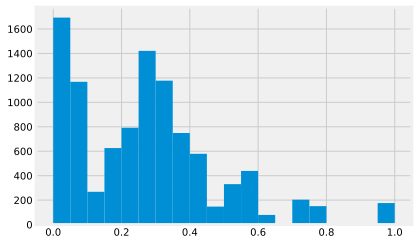

In [53]:
df1 = df.groupby('Price').mean()
fig, ax = plt.subplots()
ax.hist(df1['Social_2'],bins=20)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
plt.show()

In [54]:
np.percentile(df['Social_2'], [0, 32, 84, 94, 100])

array([0.        , 0.15485065, 0.44826857, 0.6381179 , 1.        ])

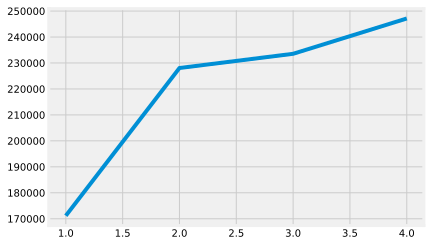

In [55]:
x11=np.percentile(df['Social_2'], [0, 32, 84, 94, 100])
df['Social_2_group']=''
df.loc[df['Social_2']<x11[1],'Social_2_group']=1
df.loc[(df['Social_2']>=x11[1])&(df['Social_2']<x11[2]),'Social_2_group']=3
df.loc[(df['Social_2']>=x11[2])&(df['Social_2']<x11[3]),'Social_2_group']=2
df.loc[df['Social_2']>=x11[3],'Social_2_group']=4

df2 = df.groupby('Social_2_group').mean()
plt.plot(df2.sort_values('Price').index,df2.sort_values('Price')['Price'])
plt.show()

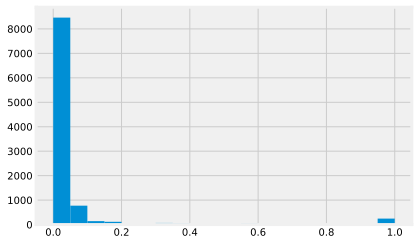

In [56]:
df1 = df.groupby('Price').mean()
fig, ax = plt.subplots()
ax.hist(df1['Social_3'],bins=20)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
plt.show()

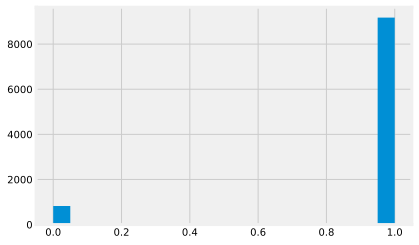

In [57]:
df1 = df.groupby('Price').mean()
fig, ax = plt.subplots()
ax.hist(df1['Shops_2'],bins=20)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
plt.show()

#### В результате проведенной генерации данных, получаем суммарную оценку по данным параметра

In [58]:
df['Score_2']=df['Square_Rooms_group']+df['Shops_1_group']+df['Helthcare_2_group']+df['HouseYear_group']+df['Rooms_group']+df['Floor_group']+df['Square_group']+df['LifeSquare_group']+df['HouseFloor_group']+df['Ecology_1_group']+df['Shops_1_group']+df['Social_2_group']+df['Social_1_group']

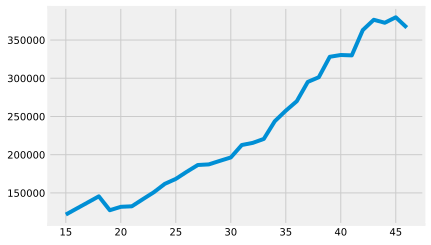

In [59]:
plt.plot(df.groupby('Score_2').mean().index,df.groupby('Score_2').mean()['Price'])

### В результате преобразований получен dataframe со следующими характеристиками

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  10000 non-null  int64  
 1   DistrictId          10000 non-null  float64
 2   Rooms               10000 non-null  float64
 3   Square              10000 non-null  float64
 4   LifeSquare          10000 non-null  float64
 5   KitchenSquare       10000 non-null  float64
 6   Floor               10000 non-null  float64
 7   HouseFloor          10000 non-null  float64
 8   HouseYear           10000 non-null  float64
 9   Ecology_1           10000 non-null  float64
 10  Ecology_2           10000 non-null  float64
 11  Ecology_3           10000 non-null  float64
 12  Social_1            10000 non-null  float64
 13  Social_2            10000 non-null  float64
 14  Social_3            10000 non-null  float64
 15  Healthcare_1        5202 non-null   float64
 16  Helth

#### Просмотр параметров (features), которые будут использованы для анализа

In [61]:
features = list(df.columns)
print(features)

['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2', 'Price', 'Score', 'Square_Rooms_group', 'Rooms_group', 'Floor_group', 'Square_group', 'LifeSquare_group', 'Helthcare_2_group', 'HouseYear_group', 'HouseFloor_group', 'Ecology_1_group', 'Shops_1_group', 'Social_1_group', 'Social_2_group', 'Score_2']


#### Удаление тех, которые уже учтены в Score и Score_2, а также Id и Price

In [62]:
features = list(df.columns)
features.remove('Id')
features.remove('Price')
features.remove('Healthcare_1')
features.remove('Rooms_group')
features.remove('Floor_group')
features.remove('Square_group')
features.remove('Square_Rooms_group')
features.remove('Helthcare_2_group')
features.remove('LifeSquare_group')
features.remove('HouseYear_group')
features.remove('HouseFloor_group')
features.remove('Ecology_1_group')
features.remove('Shops_1_group')
features.remove('Ecology_2')
features.remove('Ecology_3')
features.remove('Shops_2')
features.remove('Social_1_group')
features.remove('Social_2_group')

print(features)

['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2', 'Shops_1', 'Score', 'Score_2']


#### Использование Price в качестве целевой переменной
#### Создание датафрейма с выбранными параметрами на основе списка features

In [63]:
target = df['Price']
data_full = df[features].copy()

#### Группировка данных с использованием KMeans

In [64]:
kmeans_model = KMeans(random_state=881)
kmeans_scaler = MinMaxScaler(copy = False)
df_kmeans = kmeans_scaler.fit_transform(data_full[['DistrictId','Ecology_1','Social_1','Social_3','Helthcare_2','Shops_1']])
kmeans_labels = kmeans_model.fit_predict(df_kmeans)

data_full.insert(16,'Clusters',kmeans_labels)

#### В результате использования KMeans получилось 8 кластеров, к которым относятся квартиры с различными комбинациями 6 параметров ('DistrictId','Ecology_1','Social_1','Social_3','Helthcare_2','Shops_1'); уровень цен в них разный, но и довольно близкие кластеры по ценовой характеристике.

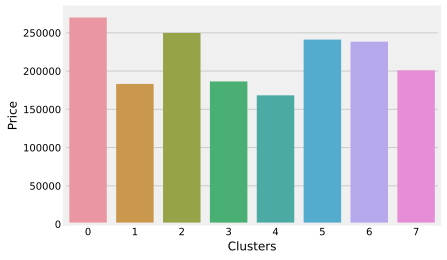

In [66]:
df.insert(loc = 15,column = 'Clusters',value = kmeans_labels)
sns.barplot(x = df.groupby('Clusters').mean().index,y = df.groupby('Clusters').mean()['Price'])
plt.show()

In [67]:
data_full.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Score,Score_2,Clusters
0,0.129187,0.6,0.381421,0.182017,0.232558,0.073171,0.077586,0.945455,0.144527,0.148649,0.154851,0.000000,0.000000,0.000000,2.0,26,4
1,0.105263,0.2,0.091828,0.056704,0.186047,0.146341,0.060345,0.509091,0.227141,0.405405,0.319270,0.007092,0.166667,0.000000,2.0,27,1
2,0.004785,0.6,0.240138,0.166360,0.232558,0.024390,0.137931,0.709091,0.049072,0.445946,0.269257,0.000000,0.500000,0.043478,2.0,30,5
3,0.004785,0.2,0.094051,0.068371,0.232558,0.219512,0.181034,0.609091,0.013648,0.013514,0.005075,0.000000,0.000000,0.043478,2.0,26,4
4,0.449761,0.4,0.186000,0.125593,0.209302,0.365854,0.129310,0.563636,0.541896,0.445946,0.449326,0.014184,0.000000,0.260870,2.0,29,7


#### К уже имеющемуся списку полей для анализа (features) нужно добавить поле 'Clusters' и удалить 'Social_2' (т.к. ранее на графике было показано, что его сложно использовать для дифференциации групп квартир

In [68]:
features.append('Clusters')
features.remove('Social_2')
target = df['Price']
data_full = df[features].copy()

#### Все готово для начала процесса обучения модели

![](1.png)

![](2.png)

![](3.png)

In [72]:
# Лучший алгоритм из этих трех - GradientBoostingRegressor
# Используем его
gbr = GradientBoostingRegressor(learning_rate = 0.01, max_depth = 4, n_estimators = 5000,min_samples_leaf=2, min_samples_split=3,subsample=0.6)
gbr.fit(x_train_scaled,y_train)
y_train_hat=gbr.predict(x_train_scaled)
y_hat=gbr.predict(x_test_scaled)
y_train_hat=gbr.predict(x_train_scaled)
print(r2_score(y_test,y_hat))

0.7625946898417698


In [73]:
# Визуализация результатов предсказаний: сравнение с реальными данными.
def evaluate_preds(true_values,pred_values):
    print('R2\t'+str(round(r2_score(true_values,pred_values),3))+'\n'+
          'MAE\t'+str(round(mean_absolute_error(true_values,pred_values),3))+'\n'+
          'MSE\t'+str(round(mean_squared_error(true_values,pred_values),3)))
    plt.figure(figsize=(10,10))
    sns.scatterplot(x=pred_values,y=true_values)
    plt.xlabel('Рассчитанные значения')
    plt.ylabel('Реальные значения')
    plt.title('Результаты расчета: сравнение с реальными данными')
    plt.show()

#### Просмотр насколько хорошо обучена модель на тренировочных данных

R2	0.921
MAE	17678.583
MSE	684750772.851


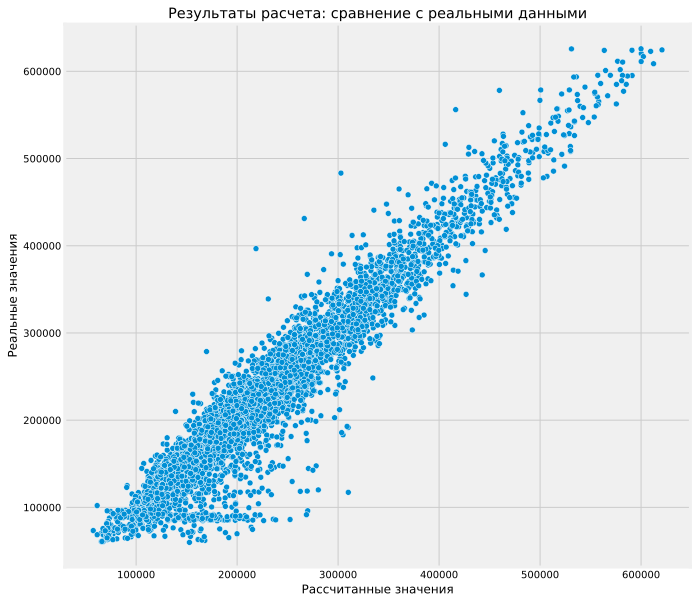

In [75]:
y_train_hat=gbr.predict(x_train_scaled)
evaluate_preds(y_train,y_train_hat)

#### Просмотр результатов работы модели на тестовой выборки, выделенной из уже имеющихся данных

R2	0.763
MAE	27031.331
MSE	2042582129.894


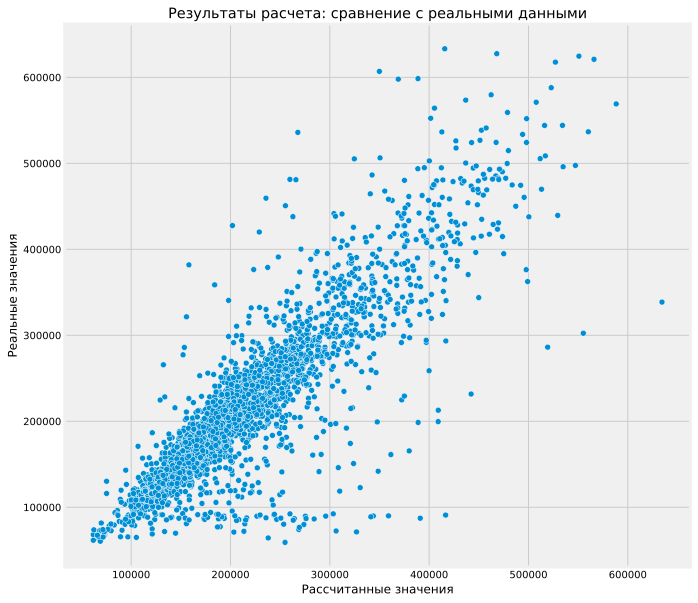

In [77]:
y_hat=gbr.predict(x_test_scaled)
evaluate_preds(y_test,y_hat)

# Часть 2
## Прогнозирование цены на тестовых данных

In [128]:
df_to_test = pd.read_csv('test.csv')
df_to_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


In [129]:
df_to_test.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,4832.674037,44.179466,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,1.000000,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,16795.000000,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


#### Проведение тех же преобразований, что и с тренировочной базой данных

In [130]:
df_to_test.loc[df_to_test['Ecology_3']=='A','Ecology_3']=0
df_to_test.loc[df_to_test['Ecology_3']=='B','Ecology_3']=-1
df_to_test.loc[df_to_test['Ecology_2']=='A','Ecology_2']=0
df_to_test.loc[df_to_test['Ecology_2']=='B','Ecology_2']=1
df_to_test.loc[df_to_test['Shops_2']=='A','Shops_2']=0
df_to_test.loc[df_to_test['Shops_2']=='B','Shops_2']=1
df_to_test.head()

df_to_test = data_correction(df_to_test)

#### Масштабирование данных с помощью уже имеющейся модели data_scaler (создана в начале исследования)

In [131]:
df_scaled = pd.DataFrame(data_scaler.transform(df_to_test.iloc[:,1:]),columns = df_to_test.iloc[:,1:].columns)
df_to_test.iloc[:,1:] = df_scaled
df_to_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,0.210526,0.2,0.080332,0.038467,0.116279,0.097561,0.068966,0.545455,0.069217,1.0,0.0,0.324324,0.222575,0.000000,0.213652,0.166667,0.043478,1.0
1,5925,0.296651,0.2,0.102363,0.143187,0.232558,0.146341,0.137931,0.972727,0.138268,1.0,0.0,0.027027,0.024372,0.007092,NaN,0.000000,0.000000,0.0
2,960,0.129187,0.4,0.167432,NaN,0.209302,0.439024,0.155172,0.609091,0.405086,1.0,0.0,0.121622,0.091145,0.000000,NaN,0.000000,0.043478,1.0
3,3848,0.110048,0.6,0.129622,0.104699,0.139535,0.024390,0.008621,0.500000,0.026967,1.0,0.0,0.027027,0.016231,0.000000,NaN,0.000000,0.000000,1.0
4,746,0.354067,0.2,0.145763,NaN,0.232558,0.170732,0.137931,0.609091,0.593023,1.0,0.0,0.472973,0.398996,0.028369,0.204166,0.000000,0.260870,1.0


#### Проверка заполненности всех полей

In [132]:
df_to_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   float64
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   float64
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   float64
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   float64
 11  Ecology_3      5000 non-null   float64
 12  Social_1       5000 non-null   float64
 13  Social_2       5000 non-null   float64
 14  Social_3       5000 non-null   float64
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   float64
 17  Shops_1        5000 non-null   float64
 18  Shops_2 

#### Генерация новых признаков (аналогично тем, что созданы для базы данных, предоставленной для обучения)

In [133]:
df_to_test['Square_Rooms_group']=''
df_to_test.loc[(df_to_test['Square']/df_to_test['Rooms'])<x0[1],'Square_Rooms_group']=1
df_to_test.loc[(df_to_test['Square']/df_to_test['Rooms']>=x0[1])&(df_to_test['Square']/df_to_test['Rooms']<x0[2]),'Square_Rooms_group']=3
df_to_test.loc[(df_to_test['Square']/df_to_test['Rooms']>=x0[2])&(df_to_test['Square']/df_to_test['Rooms']<x0[3]),'Square_Rooms_group']=2
df_to_test.loc[df_to_test['Square']/df_to_test['Rooms']>=x0[3],'Square_Rooms_group']=4
df_to_test.loc[df_to_test['Rooms']==0,'Square_Rooms_group']=4

df_to_test['Rooms_group']=''
df_to_test.loc[df_to_test['Rooms']<x1[1],'Rooms_group']=1
df_to_test.loc[(df_to_test['Rooms']>=x1[1])&(df_to_test['Rooms']<=x1[2]),'Rooms_group']=2
df_to_test.loc[(df_to_test['Rooms']>x1[2])&(df_to_test['Rooms']<=x1[3]),'Rooms_group']=3
df_to_test.loc[df_to_test['Rooms']>x1[3],'Rooms_group']=4

df_to_test['Floor_group']=''
df_to_test.loc[df_to_test['Floor']<x2[1],'Floor_group']=1
df_to_test.loc[(df_to_test['Floor']>=x2[1])&(df_to_test['Floor']<x2[2]),'Floor_group']=2
df_to_test.loc[(df_to_test['Floor']>=x2[2])&(df_to_test['Floor']<x2[3]),'Floor_group']=3
df_to_test.loc[df_to_test['Floor']>=x2[3],'Floor_group']=4

df_to_test['Square_group']=''
df_to_test.loc[df_to_test['Square']<x3[1],'Square_group']=1
df_to_test.loc[(df_to_test['Square']>=x3[1])&(df_to_test['Square']<x3[2]),'Square_group']=2
df_to_test.loc[(df_to_test['Square']>=x3[2])&(df_to_test['Square']<x3[3]),'Square_group']=3
df_to_test.loc[df_to_test['Square']>=x3[3],'Square_group']=4

df_to_test.loc[df_to_test['LifeSquare'].isna(),'LifeSquare'] = df_to_test.loc[df_to_test['LifeSquare'].isna(),'Square']/1.6
df_to_test['LifeSquare_group']=''
df_to_test.loc[df_to_test['LifeSquare']<x4[1],'LifeSquare_group']=1
df_to_test.loc[(df_to_test['LifeSquare']>=x4[1])&(df_to_test['LifeSquare']<x4[2]),'LifeSquare_group']=2
df_to_test.loc[(df_to_test['LifeSquare']>=x4[2])&(df_to_test['LifeSquare']<x4[3]),'LifeSquare_group']=3
df_to_test.loc[df_to_test['LifeSquare']>=x4[3],'LifeSquare_group']=4

df_to_test['Helthcare_2_group']=''
df_to_test.loc[df_to_test['Helthcare_2']<x5[1],'Helthcare_2_group']=1
df_to_test.loc[(df_to_test['Helthcare_2']>=x5[1])&(df_to_test['Helthcare_2']<=x5[2]),'Helthcare_2_group']=3
df_to_test.loc[(df_to_test['Helthcare_2']>x5[2])&(df_to_test['Helthcare_2']<=x5[3]),'Helthcare_2_group']=2
df_to_test.loc[df_to_test['Helthcare_2']>x5[3],'Helthcare_2_group']=4

df_to_test['HouseYear_group']=''
df_to_test.loc[df_to_test['HouseYear']<x6[1],'HouseYear_group']=4
df_to_test.loc[(df_to_test['HouseYear']>=x6[1])&(df_to_test['HouseYear']<x6[2]),'HouseYear_group']=1
df_to_test.loc[(df_to_test['HouseYear']>=x6[2])&(df_to_test['HouseYear']<x6[3]),'HouseYear_group']=3
df_to_test.loc[df_to_test['HouseYear']>=x6[3],'HouseYear_group']=2

df_to_test['HouseFloor_group']=''
df_to_test.loc[df_to_test['HouseFloor']<x7[1],'HouseFloor_group']=1
df_to_test.loc[(df_to_test['HouseFloor']>=x7[1])&(df_to_test['HouseFloor']<x7[2]),'HouseFloor_group']=2
df_to_test.loc[(df_to_test['HouseFloor']>=x7[2])&(df_to_test['HouseFloor']<x7[3]),'HouseFloor_group']=4
df_to_test.loc[df_to_test['HouseFloor']>=x7[3],'HouseFloor_group']=3

df_to_test['Ecology_1_group']=''
df_to_test.loc[df_to_test['Ecology_1']<x8[1],'Ecology_1_group']=4
df_to_test.loc[(df_to_test['Ecology_1']>=x8[1])&(df_to_test['Ecology_1']<x8[2]),'Ecology_1_group']=3
df_to_test.loc[(df_to_test['Ecology_1']>=x8[2])&(df_to_test['Ecology_1']<x8[3]),'Ecology_1_group']=2
df_to_test.loc[df_to_test['Ecology_1']>=x8[3],'Ecology_1_group']=1

df_to_test['Shops_1_group']=''
df_to_test.loc[df_to_test['Shops_1']<x9[1],'Shops_1_group']=1
df_to_test.loc[(df_to_test['Shops_1']>=x9[1])&(df_to_test['Shops_1']<x9[2]),'Shops_1_group']=3
df_to_test.loc[(df_to_test['Shops_1']>=x9[2])&(df_to_test['Shops_1']<x9[3]),'Shops_1_group']=4
df_to_test.loc[df_to_test['Shops_1']>=x9[3],'Shops_1_group']=2

df_to_test['Social_1_group']=''
df_to_test.loc[df_to_test['Social_1']<x10[1],'Social_1_group']=1
df_to_test.loc[(df_to_test['Social_1']>=x10[1])&(df_to_test['Social_1']<x10[2]),'Social_1_group']=4
df_to_test.loc[(df_to_test['Social_1']>=x10[2])&(df_to_test['Social_1']<x10[3]),'Social_1_group']=2
df_to_test.loc[df_to_test['Social_1']>=x10[3],'Social_1_group']=3

df_to_test['Social_2_group']=''
df_to_test.loc[df_to_test['Social_2']<x11[1],'Social_2_group']=1
df_to_test.loc[(df_to_test['Social_2']>=x11[1])&(df_to_test['Social_2']<x11[2]),'Social_2_group']=3
df_to_test.loc[(df_to_test['Social_2']>=x11[2])&(df_to_test['Social_2']<x11[3]),'Social_2_group']=2
df_to_test.loc[df_to_test['Social_2']>=x11[3],'Social_2_group']=4

#### Определение принадлежности к ранее созданным кластерам с помощью KMeans

In [134]:
kmeans_labels_test = kmeans_model.predict(df_to_test[['DistrictId','Ecology_1','Social_1','Social_3','Helthcare_2','Shops_1']])
df_to_test.insert(16,'Clusters',kmeans_labels_test)

#### Добавление оценок Score и Score_2

In [137]:
df_to_test['Score'] = df_to_test['Shops_2']+df_to_test['Ecology_2']+df_to_test['Ecology_3']
df_to_test['Score_2']=df_to_test['Square_Rooms_group']+\
                      df_to_test['Shops_1_group']+\
                      df_to_test['Helthcare_2_group']+\
                      df_to_test['HouseYear_group']+\
                      df_to_test['Rooms_group']+\
                      df_to_test['Floor_group']+\
                      df_to_test['Square_group']+\
                      df_to_test['LifeSquare_group']+\
                      df_to_test['HouseFloor_group']+\
                      df_to_test['Ecology_1_group']+\
                      df_to_test['Shops_1_group']+\
                      df_to_test['Social_2_group']+\
                      df_to_test['Social_1_group']

#### Создание окончательного датафрейма для предсказания цен

In [138]:
data_to_test = df_to_test[features].copy()

#### Использование готовой модели gbr для предсказания цен. Дополнительно, перед этим производится масштабирование данных.

In [139]:
data_test_scaled = scaler.transform(data_to_test[features])
y_hat=gbr.predict(data_test_scaled)
df_to_test['Price'] = y_hat
pd.DataFrame(data_test_scaled,columns = data_to_test.columns).head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_3,Helthcare_2,Shops_1,Score,Score_2,Clusters
0,0.210526,0.2,0.080332,0.037809,0.119048,0.097561,0.081633,0.545455,0.069217,0.324324,0.000000,0.166667,0.043478,0.666667,0.392857,0.714286
1,0.296651,0.2,0.102363,0.142601,0.238095,0.146341,0.163265,0.972727,0.138268,0.027027,0.007092,0.000000,0.000000,0.333333,0.142857,0.571429
2,0.129187,0.4,0.167432,0.104032,0.214286,0.439024,0.183673,0.609091,0.405086,0.121622,0.000000,0.000000,0.043478,0.666667,0.285714,0.142857
3,0.110048,0.6,0.129622,0.104087,0.142857,0.024390,0.010204,0.500000,0.026967,0.027027,0.000000,0.000000,0.000000,0.666667,0.035714,0.571429
4,0.354067,0.2,0.145763,0.090480,0.238095,0.170732,0.163265,0.609091,0.593023,0.472973,0.028369,0.000000,0.260870,0.666667,0.464286,1.000000


In [140]:
df_to_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2_group,HouseYear_group,HouseFloor_group,Ecology_1_group,Shops_1_group,Social_1_group,Social_2_group,Score,Score_2,Price
0,4567,0.210526,0.2,0.080332,0.038467,0.116279,0.097561,0.068966,0.545455,0.069217,...,3,1,2,4,1,4,3,2.0,29,168406.191833
1,5925,0.296651,0.2,0.102363,0.143187,0.232558,0.146341,0.137931,0.972727,0.138268,...,1,2,2,3,1,1,1,1.0,22,125201.934482
2,960,0.129187,0.4,0.167432,0.104645,0.209302,0.439024,0.155172,0.609091,0.405086,...,1,1,4,2,1,1,1,2.0,26,146445.514889
3,3848,0.110048,0.6,0.129622,0.104699,0.139535,0.024390,0.008621,0.500000,0.026967,...,1,1,1,4,1,1,1,2.0,19,117698.192953
4,746,0.354067,0.2,0.145763,0.091102,0.232558,0.170732,0.137931,0.609091,0.593023,...,1,1,2,2,3,2,3,2.0,31,217910.673168


#### Сохранение результатов в файл

In [141]:
df_result_csv = df_to_test[['Id','Price']]
df_result_csv.to_csv('my_predictions.csv',index=False)
df_result_csv.head()

,Id,Price
0,4567,168406.191833
1,5925,125201.934482
2,960,146445.514889
3,3848,117698.192953
4,746,217910.673168
